In this notebook, I document the analysis of the 2.5- and 3.5-week schistosome data shown in the SAM paper. This analysis will show an example of using existing batch-correction methods with SAM. In this case, the batch effect is primarily of a biological source as opposed to a technical source -- schistosome stem cells in different developmental time points ubiquitously express very different sets of genes.

Here, we make use of the `mnnpy` package (Mutual Nearest Neighbors) to correct the batch effects present in our data.

### Imports

In [1]:
from SAM import SAM
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
from mnnpy import mnn_correct as mnn_cor
import utilities as ut
import pandas as pd

%matplotlib inline

### Load & preprocess data

Load the 2.5- and 3.5-week datasets. Preprocess with default parameters. We also save a copy of this preprocessed data in `d1` and `d1`. This will be useful later on.

In [2]:
sam=SAM()
sam.load_data('../schisto2.5_tpm.csv')
sam.preprocess_data()
sam2=SAM()
sam2.load_data('../schisto3.5_tpm.csv')
sam2.preprocess_data()

d1 = sam.adata.X.copy()
d2 = sam2.adata.X.copy()

## Run SAM

Run with default parameters.

In [3]:
sam.run()
sam2.run()

RUNNING SAM
Iteration: 0, Convergence: 0.4227937081449849
Iteration: 1, Convergence: 0.09832641087449374
Iteration: 2, Convergence: 0.07322734130151079
Iteration: 3, Convergence: 0.02120345749687827
Iteration: 4, Convergence: 0.008502297947181837
Computing the UMAP embedding...
Elapsed time: 6.3656206130981445 seconds
RUNNING SAM
Iteration: 0, Convergence: 0.48981574763958907
Iteration: 1, Convergence: 0.12140106524697038
Iteration: 2, Convergence: 0.06025251333083937
Iteration: 3, Convergence: 0.02112860843553285
Iteration: 4, Convergence: 0.009633020400396137
Iteration: 5, Convergence: 0.005722694798488584
Computing the UMAP embedding...
Elapsed time: 4.841785192489624 seconds


### Correct for batch effects in 3.5-week dataset

Nanos-2 (Smp_051920) is known to be specifically expressed in a subpopulation of stem cells. We can see this in the 2.5-week analysis. 

In the 3.5-week analysis, Nanos-2 is expressed in both clusters and mixed with other markers. As a result, it seems as though the 3.5-week dataset is dominated by a set of genes that are orthogonal to the biology of interest. We can use `mnnpy` here, but using the cell cycle effect removal strategy we used in the macrophage analysis works as well.

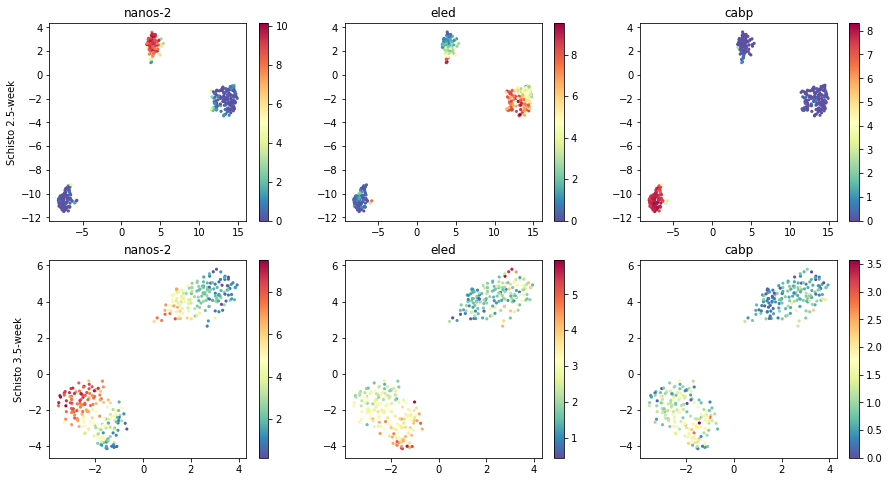

In [4]:
fig,axs = plt.subplots(2,3)
fig.set_size_inches((15,8))
genes = ['Smp_051920','Smp_041540','Smp_005350']
names = ['nanos-2', 'eled', 'cabp']
for i,g in enumerate(genes):
    sam.show_gene_expression(g,axes=axs[0,i], cmap='Spectral_r')
    sam2.show_gene_expression(g,axes=axs[1,i], cmap='Spectral_r')
    axs[0,i].set_title(names[i])
    axs[1,i].set_title(names[i])

axs[0,0].set_ylabel('Schisto 2.5-week');
axs[1,0].set_ylabel('Schisto 3.5-week');

Looking at the top-ranked gene according to SAM weights, we can see a gene highly expressed in one of the two clusters (for reproducibility sake, I fix this gene to be `Smp_161940`).

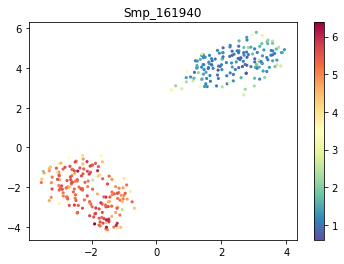

In [5]:
#gene = sam2.adata.uns['ranked_genes'][0]
gene = 'Smp_161940'
sam2.show_gene_expression(gene, cmap='Spectral_r');

Following the same general protocol we used in the macrophage analysis example (see the corresponding notebook for more details), we find all the genes correlated with the above gene and subtract them from the data.

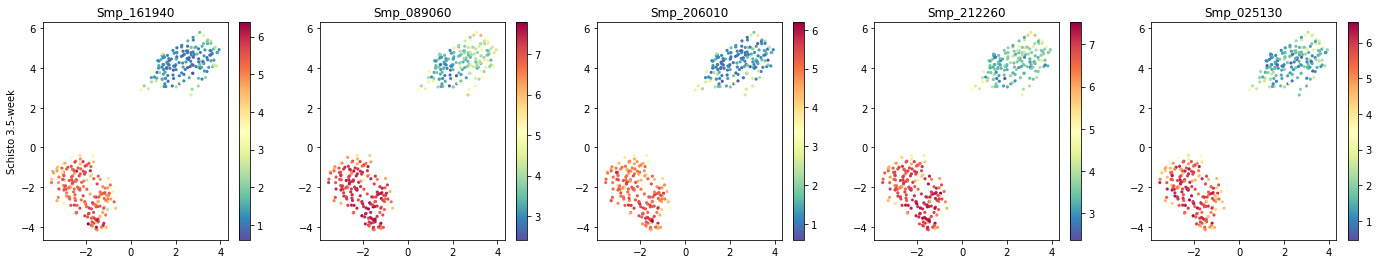

In [6]:
cgenes = ut.find_corr_genes(sam2,gene)[:200]
fig,axs = plt.subplots(1,5)
fig.set_size_inches((24,4))
for i in range(5):
    sam2.show_gene_expression(cgenes[i],axes=axs[i], cmap='Spectral_r')
    
axs[0].set_ylabel('Schisto 3.5-week');

We indeed find many genes enriched in only one of the clusters.

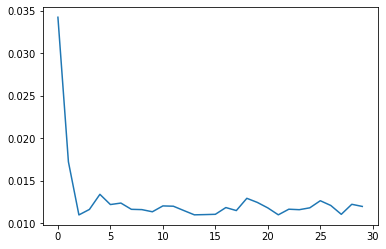

In [7]:
scores = sam2.calculate_regression_PCs(genes = ut.find_corr_genes(sam2,gene)[:200], npcs = 30);
plt.figure(); plt.plot(scores)

These genes dominate the first principal component, so we will subtract it from the data.

In [8]:
sam2.regress_genes([0])
sam2.run()

RUNNING SAM
Iteration: 0, Convergence: 0.45839551402249895
Iteration: 1, Convergence: 0.06789778624072645
Iteration: 2, Convergence: 0.05817276475346115
Iteration: 3, Convergence: 0.024385362111054236
Iteration: 4, Convergence: 0.014839506418230175
Iteration: 5, Convergence: 0.009612598066013306
Iteration: 6, Convergence: 0.006564231009609036
Iteration: 7, Convergence: 0.005000057838191244
Computing the UMAP embedding...
Elapsed time: 5.923778295516968 seconds


We can now see the same three main populations (nanos-2, eled, and cabp) in both time points, which we expected since the worms, developmentally, are not that far apart.

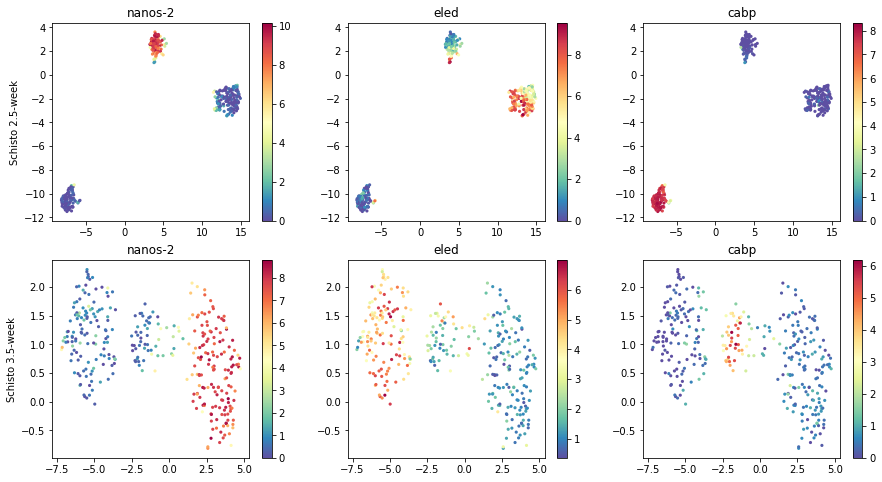

In [9]:
fig,axs = plt.subplots(2,3)
fig.set_size_inches((15,8))
genes = ['Smp_051920','Smp_041540','Smp_005350']
names = ['nanos-2', 'eled', 'cabp']
for i,g in enumerate(genes):
    sam.show_gene_expression(g,axes=axs[0,i], cmap='Spectral_r')
    sam2.show_gene_expression(g,axes=axs[1,i], cmap='Spectral_r')
    axs[0,i].set_title(names[i])
    axs[1,i].set_title(names[i])

axs[0,0].set_ylabel('Schisto 2.5-week');
axs[1,0].set_ylabel('Schisto 3.5-week');

### Correct for batch effects between 2.5-week and 3.5-week datasets

We cannot analyze both datasets together, as the result would simply be two separate clusters -- one 2.5-week cluster and one 3.5-week cluster. Thus, we must use a batch correction strategy. Here we use the Mutual Nearest Neighbor algorithm in the `mnnpy` package.

The first step is to identify highly variable genes. Here, we opt to take the 1000 genes with highest SAM weights from the two datasets.

In [10]:
W = np.vstack((sam.adata.var['weights'],sam2.adata.var['weights'])).max(0)
HVGi=np.sort(np.argsort(-W)[:1000])
HVG = sam.adata.var_names[HVGi]

We can now run the batch correction method `mnn_corr`.

In [11]:
n_jobs=4
datas=(sam.adata.X.A,sam2.adata.X.A)
datas, mnn_list, angle_list = mnn_cor(
    *datas, var_index=np.arange(datas[0].shape[1]), var_subset=HVGi, batch_key=None, index_unique='-',
    batch_categories=None, k=20, sigma=1, cos_norm_in=True, cos_norm_out=True,
    svd_dim=None, var_adj=True, compute_angle=False, mnn_order=None, svd_mode='rsvd',
    do_concatenate=True, save_raw=False, n_jobs=4)

Performing cosine normalization...
Starting MNN correct iteration. Reference batch: 0
Step 1 of 1: processing batch 1
  Looking for MNNs...
  Computing correction vectors...
  Adjusting variance...
  Applying correction...
MNN correction complete. Gathering output...


Pass in the concatenated corrected datasets into a new SAM object:

In [12]:
D = sp.sparse.csr_matrix(datas) # concatenate datasets from mnnpy output
G = sam.adata.var_names #gene names
C = np.append(sam.adata.obs_names,sam2.adata.obs_names) # concatenate cell names from two datasets
sam3=SAM(counts = (D, G, C)) #SAM can accept a (sparse expression matrix, gene IDs, cell IDs) tuple via `counts`
a=np.zeros(sam3.adata.shape[0])
a[sam.adata.shape[0]:]=1
sam3.adata.obs['batch'] = pd.Categorical(a) #save the batch IDs (0 = 2.5 week, 1 = 3.5 week)

Remember that we want to use the original preprocessed expression values for calculating the dispersions, since dispersion (e.g. the Fano factor) is not defined for negative values. We stored these in `d1` and `d2`. We will pass this data into the `'X_disp'` layer of the `AnnData` object in SAM (which is what SAM uses to calculate the spatial dispersions / SAM weights).

In [13]:
sam3.adata.layers['X_disp'] = sp.sparse.vstack((d1,d2))

Now `sam3.adata.X` contains the batch-corrected data, which SAM uses for dimensionality reduction and graph construction. And `sam3.adata.layers['X_disp']` contains the original preprocessed data, which SAM uses to calculate the spatial dispersions / SAM weights.

Finally, we run SAM on the corrected data. Here, we set `num_norm_avg=1`. Please see the parameter exploration notebook for more details about this and other parameters.

In [14]:
sam3.run(num_norm_avg=1)

RUNNING SAM
Iteration: 0, Convergence: 0.4611705741523626
Iteration: 1, Convergence: 0.2321161505482996
Iteration: 2, Convergence: 0.06528112224608713
Iteration: 3, Convergence: 0.02107268727528928
Iteration: 4, Convergence: 0.015915593362840798
Iteration: 5, Convergence: 0.00607731418684996
Computing the UMAP embedding...
Elapsed time: 20.7015163898468 seconds


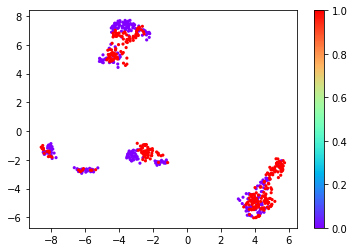

In [15]:
sam3.scatter(c='batch');

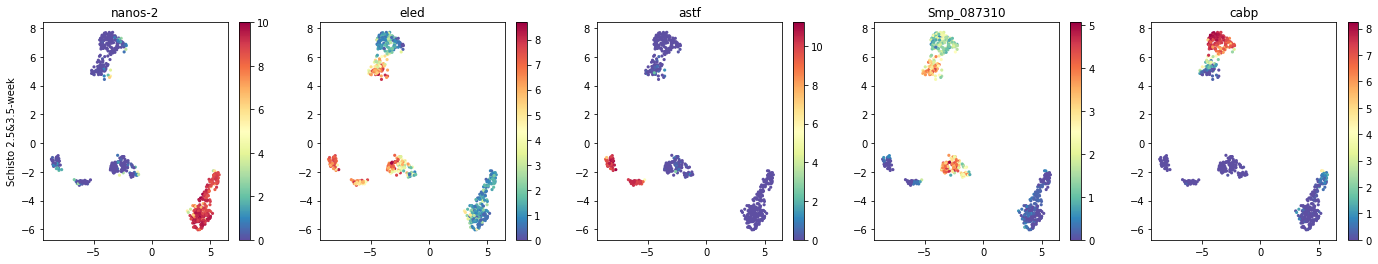

In [16]:
fig,axs = plt.subplots(1,5)
fig.set_size_inches((24,4))
genes = ['Smp_051920','Smp_041540','Smp_142120', 'Smp_087310', 'Smp_005350']
names = ['nanos-2', 'eled', 'astf','Smp_087310', 'cabp']
for i,g in enumerate(genes):
    sam3.show_gene_expression(g,axes=axs[i], cmap='Spectral_r')
    axs[i].set_title(names[i])

axs[0].set_ylabel('Schisto 2.5&3.5-week');

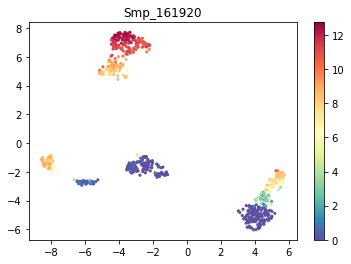

In [17]:
sam3.show_gene_expression('Smp_161920', cmap='Spectral_r');

Although it doesn't significantly affect the results of the analysis, to get the final result shown in the paper, we removed the gene `Smp_161920` (actin) as it seems to be randomly expressed in half of the cells in each population (except in the cabp population). See above.

In [ ]:
#sam3=SAM(counts = sam3.adata[:,sam3.adata.var_names!='Smp_161920'])
sam3.run(num_norm_avg=1)

RUNNING SAM
Iteration: 0, Convergence: 0.46719557645164667


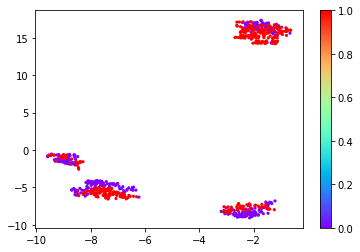

In [19]:
sam3.scatter(c=a);

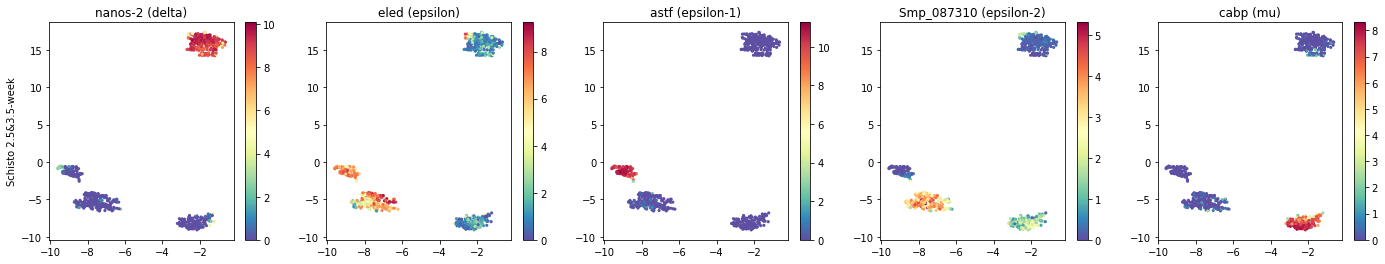

In [20]:
fig,axs = plt.subplots(1,5)
fig.set_size_inches((24,4))
genes = ['Smp_051920','Smp_041540','Smp_142120', 'Smp_087310', 'Smp_005350']
names = ['nanos-2 (delta)', 'eled (epsilon)', 'astf (epsilon-1)','Smp_087310 (epsilon-2)', 'cabp (mu)']
for i,g in enumerate(genes):
    sam3.show_gene_expression(g,axes=axs[i], cmap='Spectral_r')
    axs[i].set_title(names[i])

axs[0].set_ylabel('Schisto 2.5&3.5-week');

## SAM & Batch effects

SAM excels at identifying genes with variable expression patterns along the reconstructed manifold, even if these genes constitute unwanted sources of variation. Just like SAM can accentuate 'good' sources of variation to construct manifolds with greater structure and resolution, it can also accentuate strong 'bad' sources of variation should they exist in the data (like cell cycle effects). However, this is actually good news. The ability to clearly identify the genes associated with 'bad' sources of variation makes it easy to remove their effects from the dataset. We saw this here with removing the batch effect from the 3.5-week data as well as the cell cycle effects in the macrophage analysis.